# <center>  Классификация

## <center> Прогнозирование оттока клиентов банка

**Цель работы** — продемонстрировать изменение качества модели (метрик) в задаче классификации в зависимости от использования подходов к ее улучшению.

**Задачи работы** - построить классификатор, который позволит своевременно определять уходящих клиентов банка, оценить качество построенных моделей и проинтерпретировать результаты.




In [46]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import plotly.express as px

from sklearn import linear_model 
from sklearn import metrics 
from sklearn import model_selection 
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn import tree
from sklearn import ensemble

import warnings 
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None


**1. ПОДГОТОВКА И РАЗВЕДЫВАТЕЛЬНЫЙ АНАЛИЗ ДАННЫХ**

In [47]:
data = pd.read_csv('data/churn.csv')
display(data.head())
data.shape


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


(10000, 14)

In [48]:
data['CustomerId'].value_counts().shape # нет повторения ID
data=data.drop(columns=['CustomerId','RowNumber','Surname']) # удаляем неинформативные признаки

In [49]:
# Соотношение ушедших и лояльных клиентов

values = ['лояльные клиенты','ушедшие клиенты']

fig1 = px.pie(values=data['Exited'].value_counts(), names=values, width=500, height=400,
   title='Соотношение ушедших и лояльных клиентов')
fig1.show()

In [50]:
# Распределение ненулевого баланса пользователей

fig2 = px.histogram(x=data[data['Balance']>0]['Balance'], height=500, width=500, 
    title='Распределение ненулевого баланса пользователей')
fig2.update_layout(yaxis_title='Число пользователей (в том числе и ушедших)', xaxis_title='Баланс на счете, $')
fig2.show()

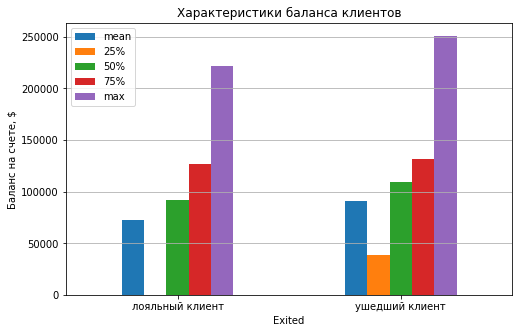

In [51]:
# Распределение баланса пользователей в зависимости от оттока. Некоторые статистические показатели

df3=data.groupby('Exited', as_index=True)['Balance'].describe().reset_index()
values = {1: 'ушедший клиент',0 : 'лояльный клиент'}
df3['Exited']=df3['Exited'].replace(values)
df3.drop(columns=['count','min','std'], inplace=True)  
#display(df3)  

df3.plot.bar(x='Exited',figsize=(8, 5), title='Характеристики баланса клиентов', ylabel='Баланс на счете, $')
plt.xticks(rotation=0)
plt.grid(axis='y')

Text(0.5, 0, 'Возраст')

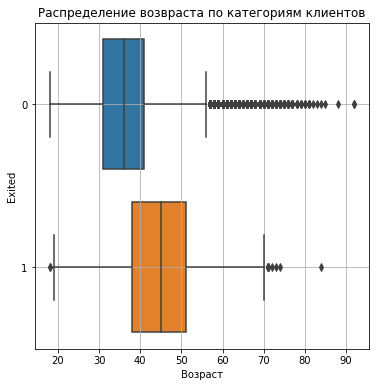

In [52]:
# Возраст пользователей в зависимости от оттока

df4=data
plt.figure(figsize=(6, 6))
sns.boxplot(data=df4, y='Exited', x='Age', orient='h')
plt.grid()
plt.title('Распределение возвраста по категориям клиентов')
plt.xlabel('Возраст')

Text(0.5, 0, 'Количество приобретенных продуктов')

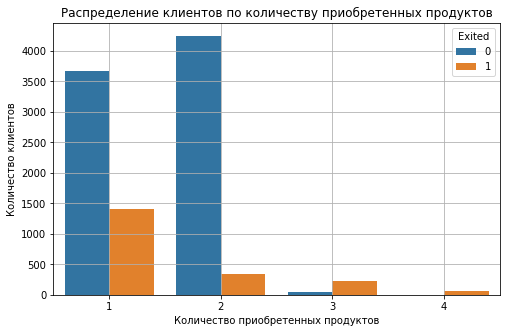

In [53]:
# Как отток клиентов зависит от числа приобретённых у банка услуг? 

df5=data[['Exited','NumOfProducts']]
df5['Count']=df5.index
df51=df5.groupby(['NumOfProducts','Exited'],as_index=False).count()

plt.figure(figsize=(8, 5))
sns.barplot(data=df51, x='NumOfProducts', y='Count', hue='Exited')
plt.grid()
plt.title('Распределение клиентов по количеству приобретенных продуктов')
plt.ylabel('Количество клиентов')
plt.xlabel('Количество приобретенных продуктов')

Text(0.5, 24.0, 'Количество лет с банком')

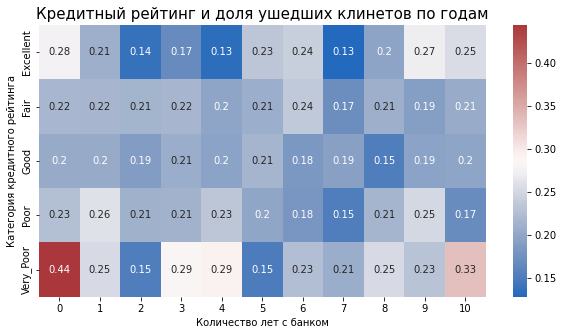

In [54]:
# Кредитный рейтинг клиентов, которые уходят чаще всего.

def get_credit_score_cat(credit_score):
    if credit_score >= 300 and credit_score < 500:
        return "Very_Poor"
    elif credit_score >= 500 and credit_score < 601:
        return "Poor"
    elif credit_score >= 601 and credit_score < 661:
        return "Fair"
    elif credit_score >= 661 and credit_score < 781:
        return "Good"
    elif credit_score >= 781 and credit_score < 851:
        return "Excellent"
    elif credit_score >= 851:
        return "Top"
    elif credit_score < 300:
        return "Deep"
    
df6=data[['Exited','CreditScore','Tenure']]
df6['CreditScore']=df6['CreditScore'].apply(get_credit_score_cat)
df61=df6.pivot_table(values='Exited',index='CreditScore',columns='Tenure',aggfunc='mean')

plt.figure(figsize=(10, 5))
sns.heatmap(data=df61, cmap='vlag', annot=True)
plt.title('Кредитный рейтинг и доля ушедших клинетов по годам', fontsize=15)
plt.ylabel('Категория кредитного рейтинга')
plt.xlabel('Количество лет с банком') 


In [55]:
# В какой стране доля ушедших клиентов больше? 

df7=data[['Geography','Exited']]
df7=df7.groupby(['Geography']).mean().round(2).reset_index()*100

fig7 = px.choropleth(
    df7, 
    scope='europe',
    locations=df7['Geography'], 
    locationmode = 'country names', 
    color=df7['Exited'], 
    range_color=[0, 35], 
    title='Ситуация по странам', 
    width=500, 
    height=500, 
    color_continuous_scale=['blue', 'red']
)

fig7.update_layout(coloraxis_colorbar=dict(title='Exited, %'))
fig7.show()

> Несмотря на то, что в ходе разведывательного анализа данных были выявлены различные факторы, влияющие на статус клиента (ушедший или лояльный), было принято решение отдать предпочтение географическому признаку - сосредоточить внимание на клиентах из Германии:

In [56]:
data=data[data['Geography'] == 'Germany']
data=data.drop(['Geography'], axis=1)

In [57]:
# data.isnull().sum() пропуски отсутствуют
# data[data.duplicated()].sum() дубликаты отсутствуют

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5]),
 [Text(0.5, 0, 'CreditScore'),
  Text(1.5, 0, 'Gender'),
  Text(2.5, 0, 'Age'),
  Text(3.5, 0, 'Tenure'),
  Text(4.5, 0, 'Balance'),
  Text(5.5, 0, 'NumOfProducts'),
  Text(6.5, 0, 'HasCrCard'),
  Text(7.5, 0, 'IsActiveMember'),
  Text(8.5, 0, 'EstimatedSalary'),
  Text(9.5, 0, 'Exited'),
  Text(10.5, 0, 'BalanceSalaryRatio'),
  Text(11.5, 0, 'TenureByAge'),
  Text(12.5, 0, 'CreditScoreGivenAge')])

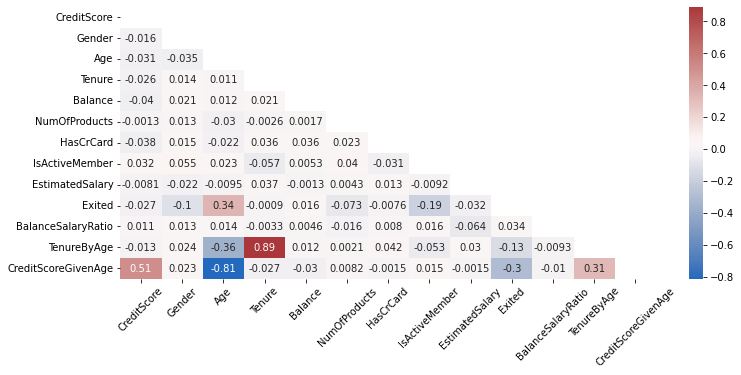

In [58]:
# создадим некоторые новые признаки

data['BalanceSalaryRatio']=data['Balance']/data['EstimatedSalary']
data['TenureByAge']=data['Tenure']/data['Age']
data['CreditScoreGivenAge']=data['CreditScore']/data['Age']
data['Gender']=data['Gender'].apply(lambda x: 1 if x=='Male' else 0)

# с появлением новых признаков стоит посмотреть на корреляцию
# не будем исключать порядковые-бинарные признаки, мы о них помним

plt.figure(figsize=(12, 5))
sns.heatmap(data.corr(), annot=True, cmap='vlag', mask=np.triu(data.corr()))
plt.xticks(rotation=45)

# Признаки с высокой корреляцией присутствуеют, будем иметь это ввиду, на всякий случай

In [59]:
# разделяем данные

X = data.drop("Exited", axis=1)
y = data["Exited"]

X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, 
    stratify=y, 
    random_state=0
)
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (1881, 12)
Test shape: (628, 12)


In [60]:
# масштабируем данные
cols=X.columns

scaler=StandardScaler().fit(X_train)
X_train_s=pd.DataFrame(scaler.transform(X_train), columns=cols)
X_test_s=pd.DataFrame(scaler.transform(X_test), columns=cols)

**2. ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ**

> Для нашего случая хорошо подойдет метрика F1, которая равна своему максимуму (1), если и precision, и recall равны 1 (то есть когда отсутствуют как ложноположительные, так и ложноотрицательные срабатывания)

In [61]:
# метрика, на которую мы ориентируемся - F1, но также приведем и иные метрики - для того, чтобы лучше понимать, что происходит с моделью

log_reg=linear_model.LogisticRegression(random_state=42, max_iter=10000)
log_reg.fit(X_train_s, y_train)
y_train_predict=log_reg.predict(X_train_s)
y_test_predict=log_reg.predict(X_test_s)
print('F1 score train: {:.2f}'.format(metrics.f1_score(y_train, y_train_predict)))
print('F1 score test: {:.2f}'.format(metrics.f1_score(y_test, y_test_predict)))
print('Accuracy score train: {:.2f}'.format(metrics.accuracy_score(y_train, y_train_predict)))
print('Accuracy score test: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_predict)))
print('Precision train {:.2f}'.format(metrics.precision_score(y_train, y_train_predict)))
print('Precision test: {:.2f}'.format(metrics.precision_score(y_test, y_test_predict)))
print('Recall train: {:.2f}'.format(metrics.recall_score(y_train, y_train_predict)))
print('Recall test: {:.2f}'.format(metrics.recall_score(y_test, y_test_predict)))

F1 score train: 0.51
F1 score test: 0.49
Accuracy score train: 0.73
Accuracy score test: 0.72
Precision train 0.63
Precision test: 0.60
Recall train: 0.43
Recall test: 0.42


> Не слишком хорошие значения метрик, модель недообучена. Попробуем добавить полиномиальные признаки

In [62]:
X_train_s3=PolynomialFeatures(degree=3, include_bias=False).fit_transform(X_train_s)
print(X_train_s3.shape) 
X_test_s3=PolynomialFeatures(degree=3, include_bias=False).fit_transform(X_test_s)
print(X_test_s3.shape) 

(1881, 454)
(628, 454)


In [63]:
log_reg_3=linear_model.LogisticRegression(random_state=42, max_iter=10000)
log_reg_3.fit(X_train_s3, y_train)
y_train_predict=log_reg_3.predict(X_train_s3)
y_test_predict=log_reg_3.predict(X_test_s3)
print('F1 score train: {:.2f}'.format(metrics.f1_score(y_train, y_train_predict)))
print('F1 score test: {:.2f}'.format(metrics.f1_score(y_test, y_test_predict)))
print('Accuracy score train: {:.2f}'.format(metrics.accuracy_score(y_train, y_train_predict)))
print('Accuracy score test: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_predict)))
print('Precision train {:.2f}'.format(metrics.precision_score(y_train, y_train_predict)))
print('Precision test: {:.2f}'.format(metrics.precision_score(y_test, y_test_predict)))
print('Recall train: {:.2f}'.format(metrics.recall_score(y_train, y_train_predict)))
print('Recall test: {:.2f}'.format(metrics.recall_score(y_test, y_test_predict)))

F1 score train: 0.77
F1 score test: 0.64
Accuracy score train: 0.86
Accuracy score test: 0.78
Precision train 0.82
Precision test: 0.69
Recall train: 0.73
Recall test: 0.60


> Введение полиномиальной зависимости значительно увеличило метрику F1 score. Теперь добавим порог вероятности. 

In [64]:
y_test_proba_pred = pd.Series(log_reg_3.predict_proba(X_test_s3)[:, 1]) 
scores = []
thresholds = np.arange(0.1, 1, 0.05) # Задаём значения порогов вероятности

# функция для подбора вероятности
def probability1 (thresholds):
    for threshold in thresholds: # В цикле перебираем значения порогов вероятности:
        y_test_pred_poly = y_test_proba_pred.apply(lambda x: 1 if x > threshold else 0) # Делаем предсказание
        score = metrics.f1_score(y_test, y_test_pred_poly)# Рассчитываем метрику
        scores.append(score) # Добавляем результат в список
        
probability1(thresholds)

максимальный F1 score: 0.6578947368421053
оптимальная вероятность: 0.30000000000000004


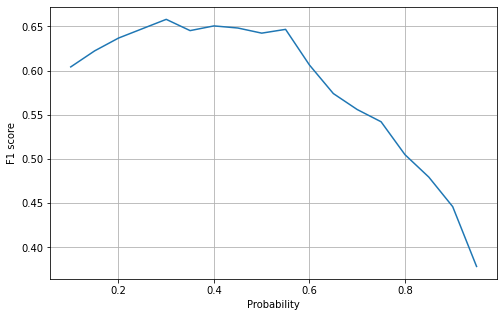

In [65]:
plt.figure(figsize=(8, 5))
sns.lineplot(x=thresholds, y=scores)
plt.grid()
plt.ylabel('F1 score')
plt.xlabel('Probability')

print('максимальный F1 score:', max(scores)) # выделим интересующий порог точно

scores_i_max=scores.index(max(scores)) # индекс максимального значения метрики 
print('оптимальная вероятность:',thresholds[scores_i_max])


In [66]:
log_reg_3.fit(X_train_s3, y_train)
y_train_predict_p=pd.Series(log_reg_3.predict_proba(X_train_s3)[:, 1]).apply(lambda x: 1 if x > thresholds[scores_i_max] else 0) 
y_test_predict_p=pd.Series(log_reg_3.predict_proba(X_test_s3)[:, 1]).apply(lambda x: 1 if x > thresholds[scores_i_max] else 0) 
print('F1 score train: {:.2f}'.format(metrics.f1_score(y_train, y_train_predict_p)))
print('F1 score test: {:.2f}'.format(metrics.f1_score(y_test, y_test_predict_p)))
print('Accuracy score train: {:.2f}'.format(metrics.accuracy_score(y_train, y_train_predict_p)))
print('Accuracy score test: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_predict_p)))
print('Precision train {:.2f}'.format(metrics.precision_score(y_train, y_train_predict_p)))
print('Precision test: {:.2f}'.format(metrics.precision_score(y_test, y_test_predict_p)))
print('Recall train: {:.2f}'.format(metrics.recall_score(y_train, y_train_predict_p)))
print('Recall test: {:.2f}'.format(metrics.recall_score(y_test, y_test_predict_p)))

F1 score train: 0.78
F1 score test: 0.66
Accuracy score train: 0.84
Accuracy score test: 0.75
Precision train 0.69
Precision test: 0.60
Recall train: 0.88
Recall test: 0.74


> Введение оптимального порога вероятности повзволило немного улучшить метрику F1 score.

**3. ДЕРЕВЬЯ РЕШЕНИЙ**

In [67]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, 
    stratify=y, 
    random_state=0
)
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (1881, 12)
Test shape: (628, 12)


In [68]:
mod_tree1=tree.DecisionTreeClassifier(criterion='entropy', random_state=42)
mod_tree1.fit(X_train, y_train)
y_train_predict=mod_tree1.predict(X_train)
y_test_predict=mod_tree1.predict(X_test)
print('F1 score train: {:.2f}'.format(metrics.f1_score(y_train, y_train_predict)))
print('F1 score test: {:.2f}'.format(metrics.f1_score(y_test, y_test_predict)))
print('Accuracy score train: {:.2f}'.format(metrics.accuracy_score(y_train, y_train_predict)))
print('Accuracy score test: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_predict)))
print('Precision train {:.2f}'.format(metrics.precision_score(y_train, y_train_predict)))
print('Precision test: {:.2f}'.format(metrics.precision_score(y_test, y_test_predict)))
print('Recall train: {:.2f}'.format(metrics.recall_score(y_train, y_train_predict)))
print('Recall test: {:.2f}'.format(metrics.recall_score(y_test, y_test_predict)))


F1 score train: 1.00
F1 score test: 0.57
Accuracy score train: 1.00
Accuracy score test: 0.73
Precision train 1.00
Precision test: 0.59
Recall train: 1.00
Recall test: 0.55


> Значение ключевой метрики F1 score (как и остальных метрик) на тренировочном наборе данных принимает свое максимальное значение. На тестовом наборе значение метрик гораздо меньше. Следовательно, модель переобучена, введенем некоторые ограничения.

In [69]:
mod_tree2=tree.DecisionTreeClassifier(criterion='entropy', random_state=42, max_depth=8, min_samples_leaf=10)
mod_tree2.fit(X_train, y_train)
y_train_predict=mod_tree2.predict(X_train)
y_test_predict=mod_tree2.predict(X_test)
print('F1 score train: {:.2f}'.format(metrics.f1_score(y_train, y_train_predict)))
print('F1 score test: {:.2f}'.format(metrics.f1_score(y_test, y_test_predict)))
print('Accuracy score train: {:.2f}'.format(metrics.accuracy_score(y_train, y_train_predict)))
print('Accuracy score test: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_predict)))
print('Precision train {:.2f}'.format(metrics.precision_score(y_train, y_train_predict)))
print('Precision test: {:.2f}'.format(metrics.precision_score(y_test, y_test_predict)))
print('Recall train: {:.2f}'.format(metrics.recall_score(y_train, y_train_predict)))
print('Recall test: {:.2f}'.format(metrics.recall_score(y_test, y_test_predict)))

F1 score train: 0.72
F1 score test: 0.64
Accuracy score train: 0.83
Accuracy score test: 0.79
Precision train 0.80
Precision test: 0.71
Recall train: 0.65
Recall test: 0.58


> Ограничение дерева способствует улучшению метрик на тестовом наборе данных. Попробуем пременить RandomForest.

In [70]:
rand_forest1=ensemble.RandomForestClassifier(n_estimators=500,criterion='entropy', random_state=42, max_depth=8, min_samples_leaf=10)
rand_forest1.fit(X_train, y_train)
y_train_predict=rand_forest1.predict(X_train)
y_test_predict=rand_forest1.predict(X_test)
print('F1 score train: {:.2f}'.format(metrics.f1_score(y_train, y_train_predict)))
print('F1 score test: {:.2f}'.format(metrics.f1_score(y_test, y_test_predict)))
print('Accuracy score train: {:.2f}'.format(metrics.accuracy_score(y_train, y_train_predict)))
print('Accuracy score test: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_predict)))
print('Precision train {:.2f}'.format(metrics.precision_score(y_train, y_train_predict)))
print('Precision test: {:.2f}'.format(metrics.precision_score(y_test, y_test_predict)))
print('Recall train: {:.2f}'.format(metrics.recall_score(y_train, y_train_predict)))
print('Recall test: {:.2f}'.format(metrics.recall_score(y_test, y_test_predict)))

F1 score train: 0.74
F1 score test: 0.66
Accuracy score train: 0.85
Accuracy score test: 0.80
Precision train 0.86
Precision test: 0.75
Recall train: 0.64
Recall test: 0.58


> Метрика F1 score немного увеличилась по сравнению с моделью обычного дерева с ограничениями. Введем порог вероятности.

In [71]:
y_test_proba_pred = pd.Series(rand_forest1.predict_proba(X_test)[:, 1]) 
scores2 = []
thresholds2 = np.arange(0.1, 1, 0.05) # Задаём значения порогов вероятности

# функция для подбора вероятности
def probability2 (thresholds):
    for threshold in thresholds: # В цикле перебираем значения порогов вероятности:
        y_test_pred = y_test_proba_pred.apply(lambda x: 1 if x > threshold else 0) # Делаем предсказание
        score = metrics.f1_score(y_test, y_test_pred)# Рассчитываем метрику
        scores2.append(score) # Добавляем результат в список
        
probability2(thresholds2)

максимальный F1 score: 0.6975717439293598
оптимальная вероятность: 0.3500000000000001


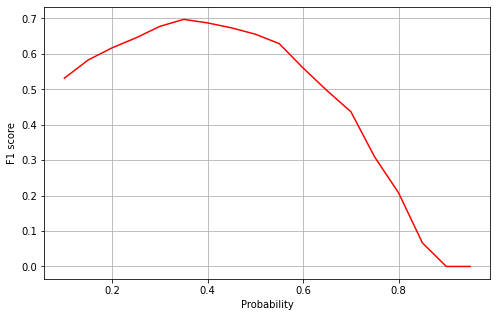

In [72]:
plt.figure(figsize=(8, 5))
sns.lineplot(x=thresholds2, y=scores2, color='red')
plt.grid()
plt.ylabel('F1 score')
plt.xlabel('Probability')

print('максимальный F1 score:', max(scores2)) # выделим интересующий порог точно

scores2_i_max=scores2.index(max(scores2)) # индекс максимального значения метрики 
print('оптимальная вероятность:',thresholds2[scores2_i_max])

In [73]:
rand_forest1.fit(X_train, y_train)
y_train_predict_p=pd.Series(rand_forest1.predict_proba(X_train)[:, 1]).apply(lambda x: 1 if x > thresholds2[scores2_i_max] else 0) 
y_test_predict_p=pd.Series(rand_forest1.predict_proba(X_test)[:, 1]).apply(lambda x: 1 if x > thresholds2[scores2_i_max] else 0) 
print('F1 score train: {:.2f}'.format(metrics.f1_score(y_train, y_train_predict_p)))
print('F1 score test: {:.2f}'.format(metrics.f1_score(y_test, y_test_predict_p)))
print('Accuracy score train: {:.2f}'.format(metrics.accuracy_score(y_train, y_train_predict_p)))
print('Accuracy score test: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_predict_p)))
print('Precision train {:.2f}'.format(metrics.precision_score(y_train, y_train_predict_p)))
print('Precision test: {:.2f}'.format(metrics.precision_score(y_test, y_test_predict_p)))
print('Recall train: {:.2f}'.format(metrics.recall_score(y_train, y_train_predict_p)))
print('Recall test: {:.2f}'.format(metrics.recall_score(y_test, y_test_predict_p)))

F1 score train: 0.77
F1 score test: 0.70
Accuracy score train: 0.84
Accuracy score test: 0.78
Precision train 0.73
Precision test: 0.63
Recall train: 0.81
Recall test: 0.77


> Введение оптимального порога вероятности повзволило немного улучшить метрику F1 score.



**4. РЕЗУЛЬТАТЫ**

In [74]:
# сводная таблица с метриками моделей

df_fin=pd.DataFrame({'Модель':['простая лог.регрессия','лог.регрессия с пол.признаками ',
                               'простое дерево с ограничениями','randomforest с ограничениями'],
                     'F1 score Train':['0.51','0.78','0.72','0.77'],
                     'F1 score Test':['0.49','0.66','0.64','0.70',]})
display(df_fin)

,Модель,F1 score Train,F1 score Test
0,простая лог.регрессия,0.51,0.49
1,лог.регрессия с пол.признаками,0.78,0.66
2,простое дерево с ограничениями,0.72,0.64
3,randomforest с ограничениями,0.77,0.70


> Модель на основе RandomForest с порогом вероятности показывает наилучшие значения метрик. Это лишний раз подвтерждает то, что данный алгоритм является одним из самых мощных;

> При этом, возможно, мы могли бы еще немного улучшить метрики, например, углубить предварительный анализ данных, избавиться от сильной корреляции признаков и т.д.

In [75]:
# Для примера предскажем класс для клиента с признаками в соотв. с dic1

dicV={
    'CreditScore': [601.0],
    'Gender': ['Male'],
    'Age': [42.0],
    'Tenure': [1.0],
    'Balance': [98495.72],
    'NumOfProducts': [1.0],
    'HasCrCard': [1.0],
    'IsActiveMember': [0.0],
    'EstimatedSalary': [40014.76]
}

df1=pd.DataFrame.from_dict(dicV)
df1['BalanceSalaryRatio']=df1['Balance']/df1['EstimatedSalary']
df1['TenureByAge']=df1['Tenure']/df1['Age']
df1['CreditScoreGivenAge']=df1['CreditScore']/df1['Age']
df1['Gender']=df1['Gender'].apply(lambda x: 1 if x=='Male' else 0)

X_V=df1
y_pred_V = rand_forest1.predict(X_V)
y_pred_V_proba = rand_forest1.predict_proba(X_V)

print('прогнозируемый класс:',y_pred_V)
print('вероятность принадлежности к классу [1]:',y_pred_V_proba[0,1].round(2))


прогнозируемый класс: [1]
вероятность принадлежности к классу [1]: 0.61
